# Example 2: simple vinyl polymers
This demo is similar in spirit to the [previous demo](1-nylon-basic.ipynb), but demonstrates how use polymerist's reaction and building capabilities  
for polymerizations involving interactions between a single "type" of monomer, as is common in vinyl polymerizations

## Output config

In [1]:
import logging
logging.basicConfig(level=logging.INFO, force=True)

from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, enable_kekulized_drawing


# Molecule drawing settings
MOL_IMG_WIDTH  : int = 400
MOL_IMG_HEIGHT : int = 300
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

enable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


## Define chemically-complete monomer "feedstocks"
We define a handful some common vinyl monomers here, which you can choose from at will

In [ ]:
a = 1 / 0 

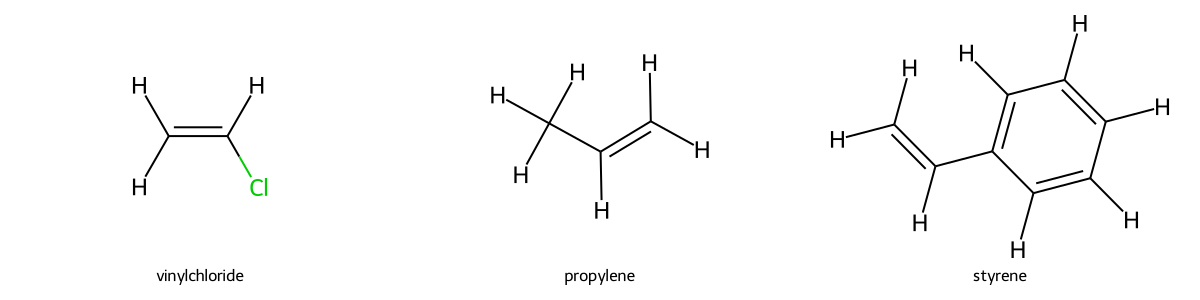

In [2]:
from rdkit.Chem.rdchem import Mol
from polymerist.rdutils.sanitization import explicit_mol_from_SMILES, Smiles


monomer_smiles : dict[str, Smiles] = {
    'vinylchloride' : 'C=CCl',
    'propylene'     : 'CC=C',
    'styrene'       : 'c1ccccc1C=C',
}
monomers : dict[str, Mol] = {
    name : explicit_mol_from_SMILES(smiles)
        for name, smiles in monomer_smiles.items()
}

MolsToGridImage(monomers.values(), molsPerRow=len(monomers), subImgSize=MOL_IMG_SIZE, legends=monomers.keys())

Unlike the previous demo, here we select **only 1** of the monomers defined to participate in polymerization; the reason for this will become clear shortly

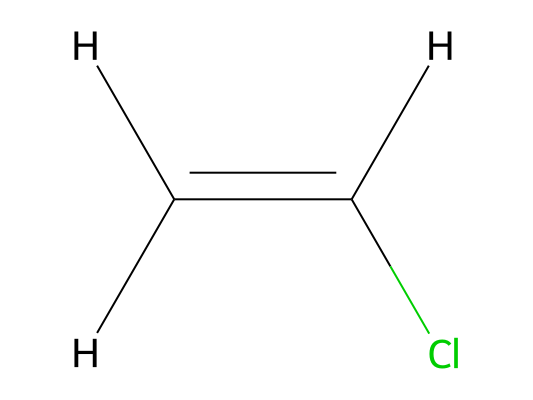

In [3]:
## choose a monomer here!
monomer_name : str = 'vinylchloride'
# monomer_name : str = 'propylene'
# monomer_name : str = 'styrene'

monomer = monomers[monomer_name] # will raise KeyError if you pick a monomer that was not defined above
display(monomer)
polymer_name = f'poly{monomer_name}'

## Define reaction template for polymerization reaction
For simplicity, we disregard initiation and consider one of the end groups of the polymer to be an unreacted vinyl

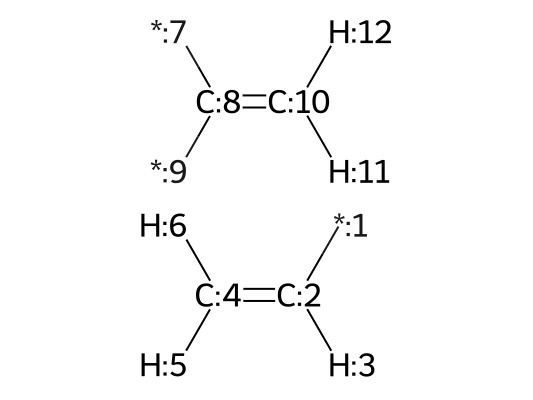

In [4]:
from rdkit.Chem.rdmolfiles import MolFromSmarts, MolToSmiles
from polymerist.rdutils.reactions import ReactionAssembler


assem = ReactionAssembler(
    reactive_groups=[
        MolFromSmarts('*-C(-[H])=C(-[H])(-[H])'), # terminal vinyl
        MolFromSmarts('*-C(-*)=C(-[H])(-[H])'),   # vinyl with R-group (could be part of monomer or existing chain)
    ],
    byproducts=[], # no byproducts in this case
    rxn_name='vinyl step growth',
)
display(assem.reactants)

In the bond derangement definition, note that one of the bond breakages is in fact the double bond in the middle vinyl;  

Polymerist's bond splicing implementation is smart enough to known that this should reduce the bond order from double to single  
and form a new bond to H, rather than dissolving the vinyl bond completely, preserving conservation of bonds and atoms 

INFO:polymerist.rdutils.bonding.permutation:3 --x-> 2


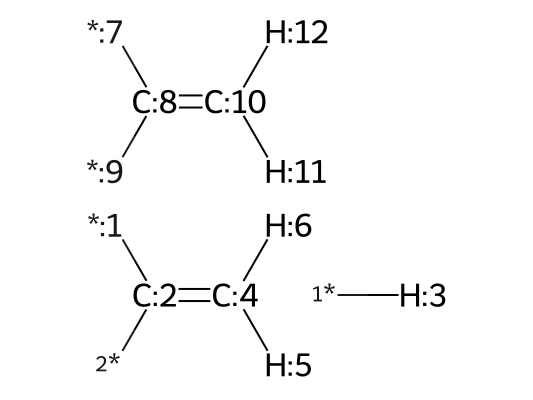

INFO:polymerist.rdutils.bonding.permutation:10 --x-> 8


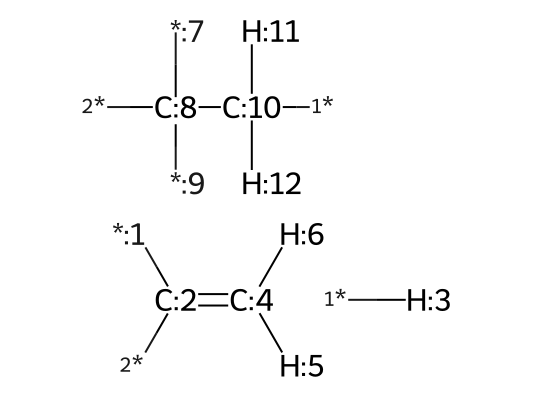

INFO:polymerist.rdutils.bonding.permutation:3 ----> 8


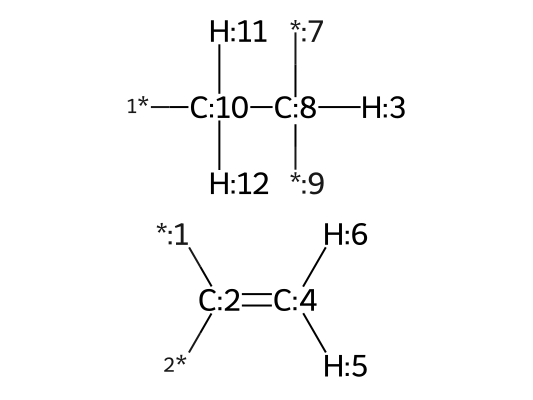

INFO:polymerist.rdutils.bonding.permutation:10 ----> 2


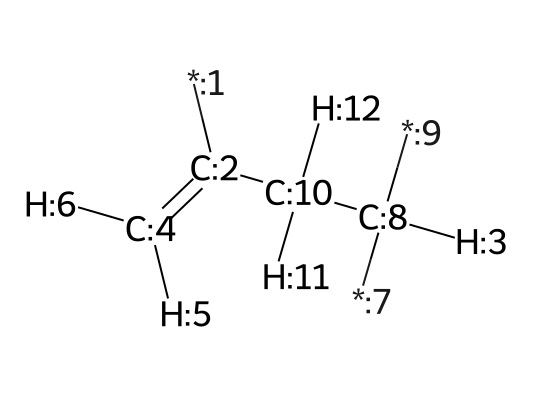

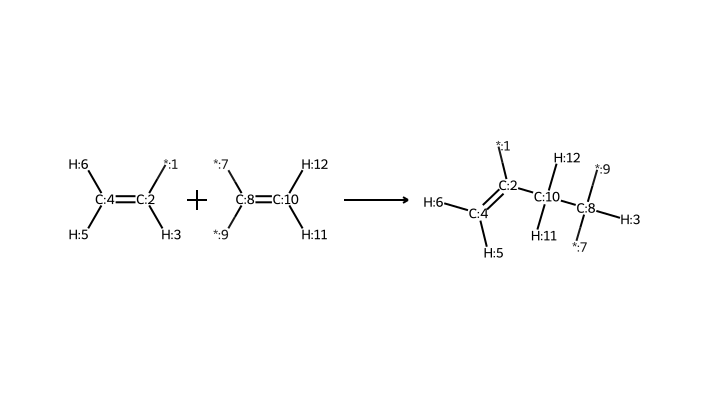

In [5]:
assem.bond_derangement = {
    3 :  (2, 8), # H:3, which was connected to C:2, should reconnect to C:8
    10 : (8, 2), # C:10, which was double bonded to C:8, should link to C:2 (and only become singly-bonded to C:10)
} # note that this forms a closed bond cycle, since atoms 2 and 8 each gain and lose 1 bond, respectively, amounting to no net valence change

rxn = assem.assemble_rxn(show_steps=True)
rxn_smarts = rxn.to_smarts()
display(rxn)

### Export reaction for re-use

In [6]:
from polymerist.genutils.fileutils import assemble_path


rxn_smarts = rxn.to_smarts()
rxn_path = assemble_path('polymer_build_files/rxns', prefix=rxn.rxnname, extension='rxn')
rxn_path.parent.mkdir(exist_ok=True, parents=True)
rxn.to_rxnfile(rxn_path)

## Enumerate all possible repeat unit fragments from monomers and reaction template
Unlike the "simpler" nylon demo, the vinyl polymers shown here form via autopolymerization  
We select a _single_ prototype monomer and allow it to interact with itself (via "resampling"),  
rather than defining distinct monomers which are only allowed to interact with each other

This is physically analogous to having many copies of a monomer in solution which interact with copies of one another, as would occur in an experimental synthesis

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 2 new fragments formable after at least 1 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 2 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 1 new fragments formable after at least 2 reaction step(s)


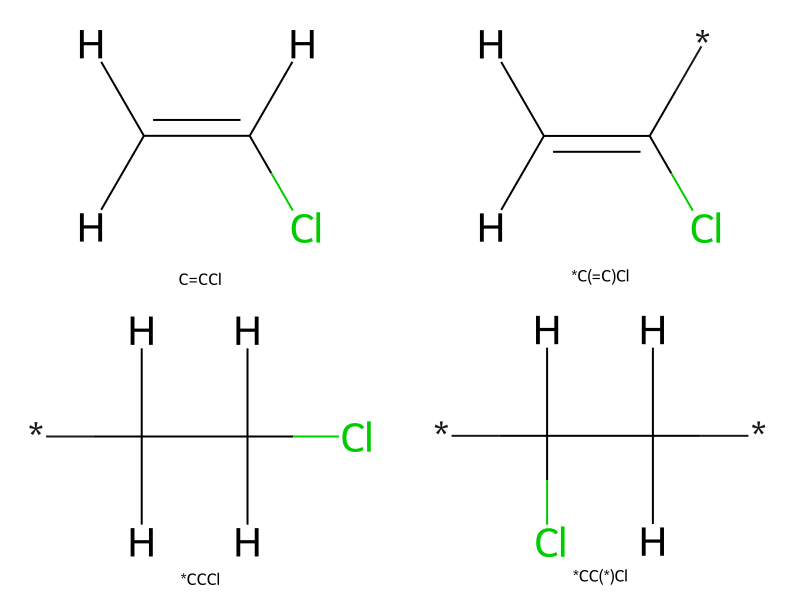

In [7]:
from polymerist.rdutils.reactions import AnnotatedReaction, PolymerizationReactor


reactor = PolymerizationReactor(rxn_schema=AnnotatedReaction.from_smarts(rxn_smarts))
fragments = reactor.propagate_pooled(
    [monomer],               # just one monomer necessary...
    allow_resampling=True,   # ... which is allowed to interact with copies of itself
    rxn_depth_max=2,         # limit reaction depth, since vinyls can (in principle) propagate indefinitely
    clear_dummy_labels=True, # this makes identifying fragment superstructure easier in the following step
)
MolsToGridImage(fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=fragments.keys())

### Generate monomer specification-compliant SMARTS with informative names for each non-monomer fragment
Since we have more than one fragment type of the same functionality from the same monomer, we assign suffixes procedurally to distinguish them

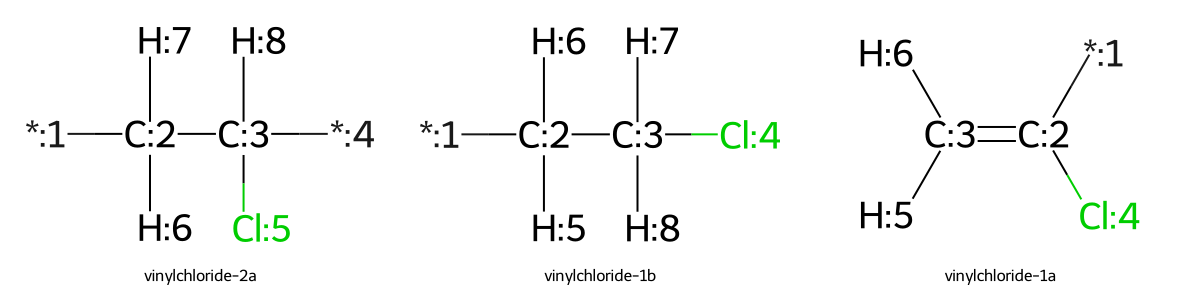

In [8]:
from string import ascii_lowercase
from collections import defaultdict, Counter

from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports
from polymerist.genutils.iteration import sort_dict_by_keys


named_fragments : dict[str, Smiles] = {}
fragment_name_modifiers = defaultdict(Counter) # keeps track of how many times each (monomer name, functionality) pair is found to generate distinguishing suffixes
for canon_smiles, fragment_mol in fragments.items():
    functionality = get_num_ports(fragment_mol)
    if functionality == 0:
        continue # skip fragments with no ports, as these are not useful for polymerization
    
    suffix = ascii_lowercase[fragment_name_modifiers[monomer_name][functionality]]
    named_fragments[f'{monomer_name}-{functionality}{suffix}'] = canon_smiles
    fragment_name_modifiers[monomer_name][functionality] += 1
    
monogrp = MonomerGroup(sort_dict_by_keys(named_fragments, reverse=True)) # sorting is not necessary for any functionality, but groups like fragments together for viewing 
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=3, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

## Use fragments to assemble a polymer

In [9]:
from polymerist.polymers.building import build_linear_polymer


# these are for you to configure
n_monomers : int = 100
do_energy_min : bool = False # if enable, will yield more physically-plausible structure, at the cost of slower structure output

monogrp.term_orient = {
    'head' : f'{monomer_name}-1a',
    'tail' : f'{monomer_name}-1b',
}
chain = build_linear_polymer(
    monomers=monogrp,
    sequence='A',
    n_monomers=n_monomers,
    energy_minimize=do_energy_min, # disabling this will make PDB generation much faster but give less physical structures
)
chain.visualize()

[22:17:00] WARNING: not removing hydrogen atom with dummy atom neighbors
INFO:polymerist.polymers.monomers.repr:Using user-defined terminal group orientation {'head': 'vinylchloride-1a', 'tail': 'vinylchloride-1b'}
INFO:polymerist.polymers.building.sequencing:Sequence kernel "A" is already fully reduced; no changes made
INFO:polymerist.polymers.building.linear:Target chain length achievable with 98 whole 1-sequence repeat(s), namely with the sequence [vinylchloride-1a] + 98*[A] + [vinylchloride-1b]
INFO:polymerist.polymers.building.linear:Registering middle monomer vinylchloride-2a (block identifier "A")
INFO:polymerist.polymers.building.linear:Registering terminal monomer vinylchloride-1a (orientation "head")
INFO:polymerist.polymers.building.linear:Registering terminal monomer vinylchloride-1b (orientation "tail")
INFO:polymerist.polymers.building.linear:Assembling linear 100-mer chain (estimated 600 atoms)
INFO:polymerist.polymers.building.linear:Successfully assembled linear 100-me

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Export polymer structure files

In [10]:
from pathlib import Path

structures_dir = Path('polymer_build_files/structures') / polymer_name
structures_dir.mkdir(exist_ok=True, parents=True)

### Export to SDFile

In [11]:
from rdkit.Chem.rdmolfiles import SDWriter
from polymerist.polymers.building import mbmol_to_rdmol


sdf_path = assemble_path(structures_dir, prefix=polymer_name, postfix=f'{n_monomers}mer', extension='sdf')
with SDWriter(sdf_path) as writer:
    writer.write(mbmol_to_rdmol(chain))

### Export to PDB File

In [12]:
from polymerist.polymers.building import mbmol_to_openmm_pdb


pdb_path = assemble_path(structures_dir, prefix=polymer_name, postfix=f'{n_monomers}mer', extension='pdb')
pdb_path.parent.mkdir(exist_ok=True, parents=True)
mbmol_to_openmm_pdb(pdb_path, chain)

### Save repeat unit fragments to disc

In [13]:
fragments_path = assemble_path('polymer_build_files/fragments', prefix=polymer_name, extension='json')
fragments_path.parent.mkdir(exist_ok=True, parents=True)
monogrp.to_file(fragments_path)